In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import SphericalVoronoi, cKDTree
from scipy import sparse
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)
import sys
import pickle
import copy
from glob import glob
from importlib import reload

sys.path.append('/science/users/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repository/tools')
import plot
import community
import fieldsetter_cmems
import advectParticles

Stripy is not available on this machine.


In [2]:
reload(plot)
reload(community)
reload(fieldsetter_cmems)
reload(advectParticles)

Stripy is not available on this machine.


<module 'advectParticles' from '/science/users/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
readDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030/"
meanDir = "/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/"
fieldFiles = sorted(glob(readDir + "mercatorglorys12v1_gl12_mean_*.nc"))

writedir = '/scratch/DaanR/psets/'

psetdir = "/data/oceanparcels/output_data/data_Daan/psets/"
matdir = "/data/oceanparcels/output_data/data_Daan/matrices/"
netdir = "/data/oceanparcels/output_data/data_Daan/networks/"
comdir = "/data/oceanparcels/output_data/data_Daan/communities/"

In [4]:
fieldset = fieldsetter_cmems.create(20010101, 1, antiBeach=False)

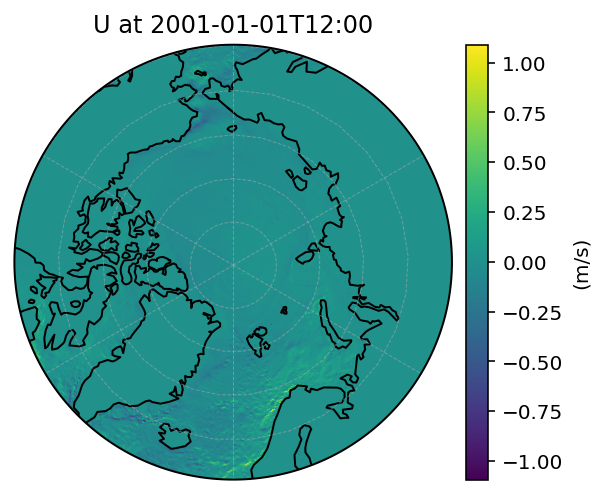

In [5]:
fig, ax = plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))
plt.show()

In [5]:
with open('/scratch/DaanR/meshes/ico_mesh_hex_r7.pickle', 'rb') as meshPick:
    meshDict = pickle.load(meshPick)
myBins = community.hexCountBins(meshDict['points'], 
                                np.degrees(meshDict['lons']), 
                                np.degrees(meshDict['lats']), 
                                meshDict['permutation'], 
                                meshDict['simplices'])
myMask = community.hexMask(myBins, -180, 180, 60, 90)
myMask.growToLevel(4)
myBins.calculate_voronoi(myMask, innerMaskLevel=2, outerMaskLevel=3)
#myBins.add_regular_rim()
myBins.calculate_neighbors()
del meshDict
with open("oceanMask_no_rim.pickle", 'rb') as pickFile:
    myBins.oceanMask = pickle.load(pickFile)

In [6]:
myParts = community.particles.from_pickle('/scratch/DaanR/meshes/ico_mesh_parts_deg_arctic_r11_delland.pickle')
print("Number of particles:", myParts.n)

Number of particles: 1450665


In [10]:
# myBins.oceanMask_from_particles(myParts, fieldset=fieldset)
# with open("oceanMask_no_rim.pickle", "wb") as pickFile:
#     pickle.dump(myBins.oceanMask, pickFile)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

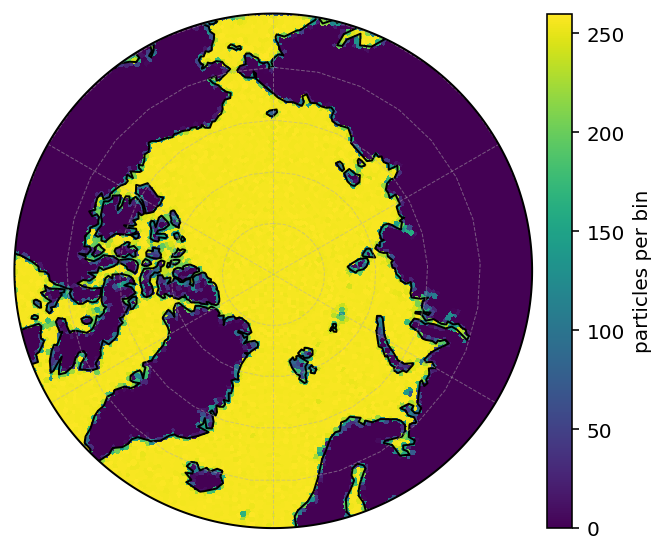

In [22]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             myBins.initCount[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]],
                                             latRange = (60, 90),
                                             polar = True,
                                             units = "particles per bin",
                                             export = "particle_initialization_C7_P11.eps",
                                             size=(5,5))

## March 2009-2018 (90 Days)

In [7]:
avg_mixing_march_2009_2018 = np.zeros_like(myBins.bindex)
avg_coherence_march_2009_2018 = np.zeros_like(myBins.bindex)
avg_boundary_march_2009_2018 = np.zeros_like(myBins.bindex)
avg_global_mixing_march_2009_2018 = 0
avg_global_coherence_march_2009_2018 = 0

for year in range(2009, 2019):
    runName = f"Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24"
    comName = runName + "_Cico7_mt2"
    
    transMat = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")
    
    myBins.load_communities(comdir + f"masked_network_{comName}.clu")
    myBins.find_adjacency();
    myBins.flag_on_boundary();
    myBins.color_communities();
    myBins.calculate_coherence_ratio(transMat);
    myBins.calculate_global_coherence()
    myBins.calculate_mixing(transMat);
    myBins.calculate_global_mixing()
    
    avg_mixing_march_2009_2018 = avg_mixing_march_2009_2018 + myBins.mixing
    avg_coherence_march_2009_2018 = avg_coherence_march_2009_2018 + myBins.coherenceRatio
    avg_boundary_march_2009_2018 = avg_boundary_march_2009_2018 + myBins.onBoundary
    avg_global_coherence_march_2009_2018 += myBins.globalCoherenceRatio
    avg_global_mixing_march_2009_2018 += myBins.globalMixing
    
avg_mixing_march_2009_2018 = avg_mixing_march_2009_2018/10
avg_coherence_march_2009_2018 = avg_coherence_march_2009_2018/10
avg_boundary_march_2009_2018 = avg_boundary_march_2009_2018/10
avg_global_mixing_march_2009_2018 = avg_global_mixing_march_2009_2018/10
avg_global_coherence_march_2009_2018 = avg_global_coherence_march_2009_2018/10
print("Average Global Coherence Ratio", avg_global_coherence_march_2009_2018)
print("Average Global Mixing Parameter", avg_global_mixing_march_2009_2018)

Average Global Coherence Ratio 0.7905477252621226
Average Global Mixing Parameter 0.3356661193382073


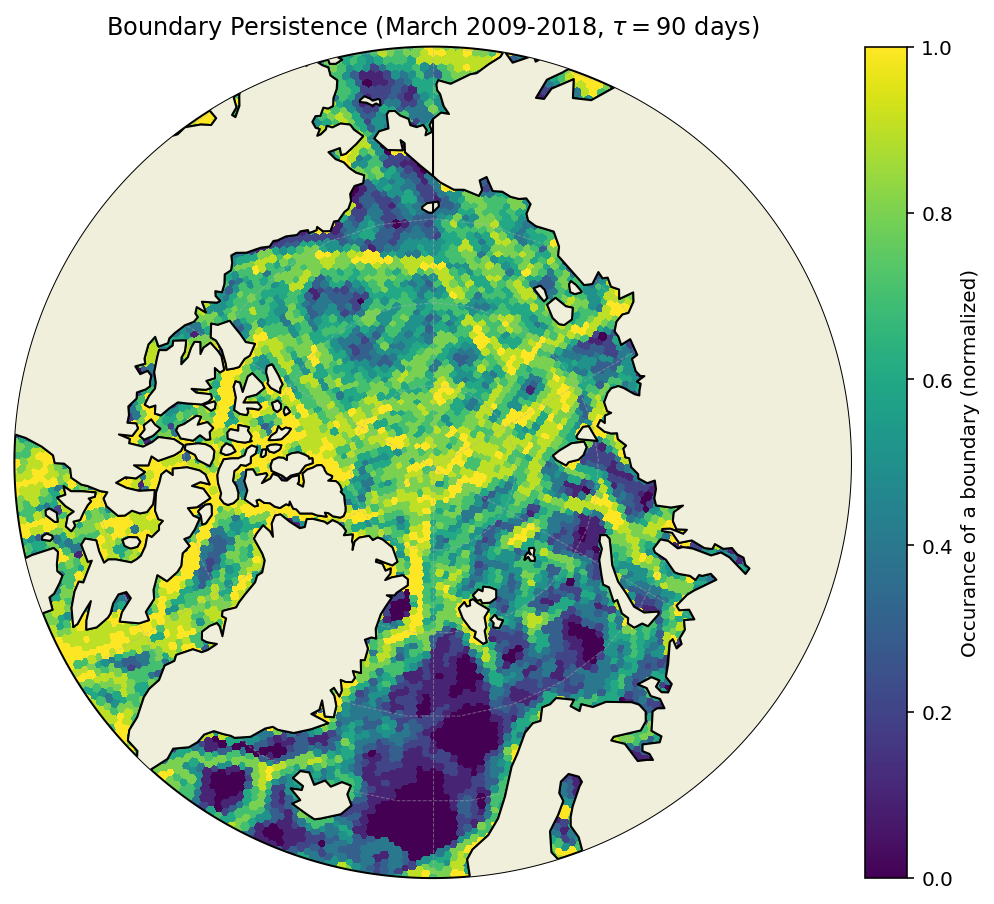

In [12]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_march_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (8,8),
                                             export = f"persistence_Rcmems_Pico11_S20092018-3-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Boundary Persistence (March 2009-2018, $\tau=90$ days)",
                                             units = "Occurance of a boundary (normalized)"
                                            )

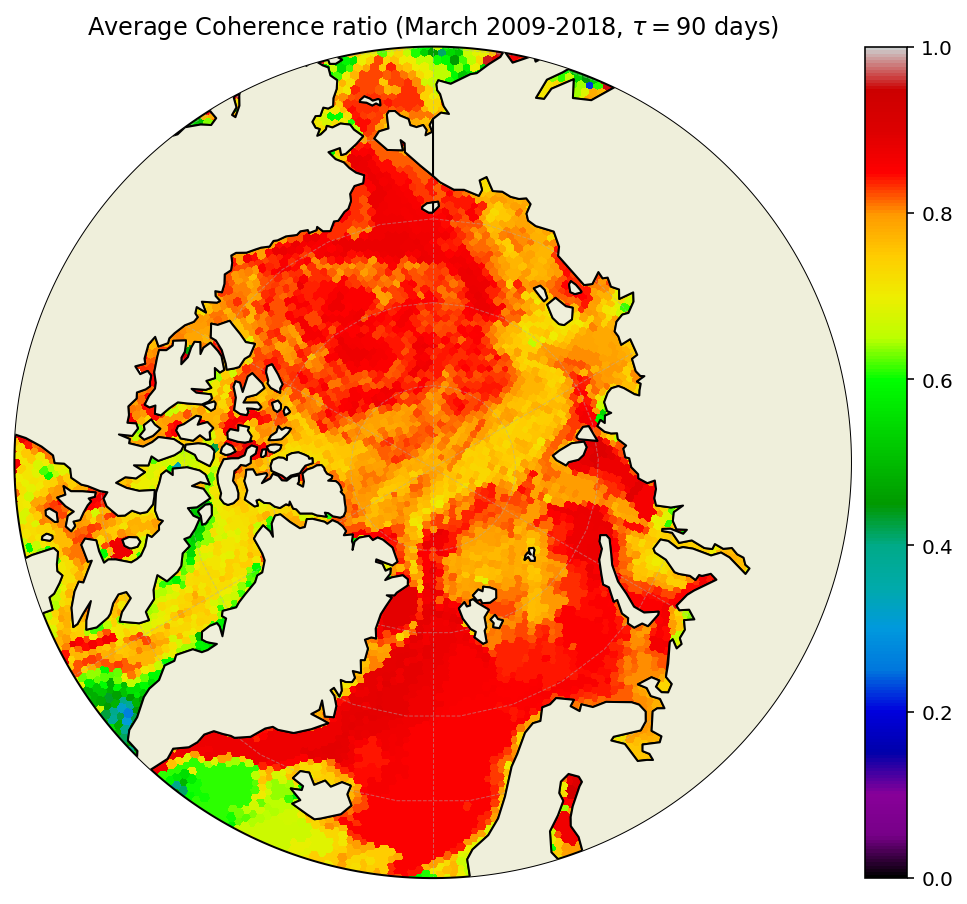

In [13]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_march_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"coherence_Rcmems_Pico11_S20092018-3-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Coherence ratio (March 2009-2018, $\tau=90$ days)",
                                            )

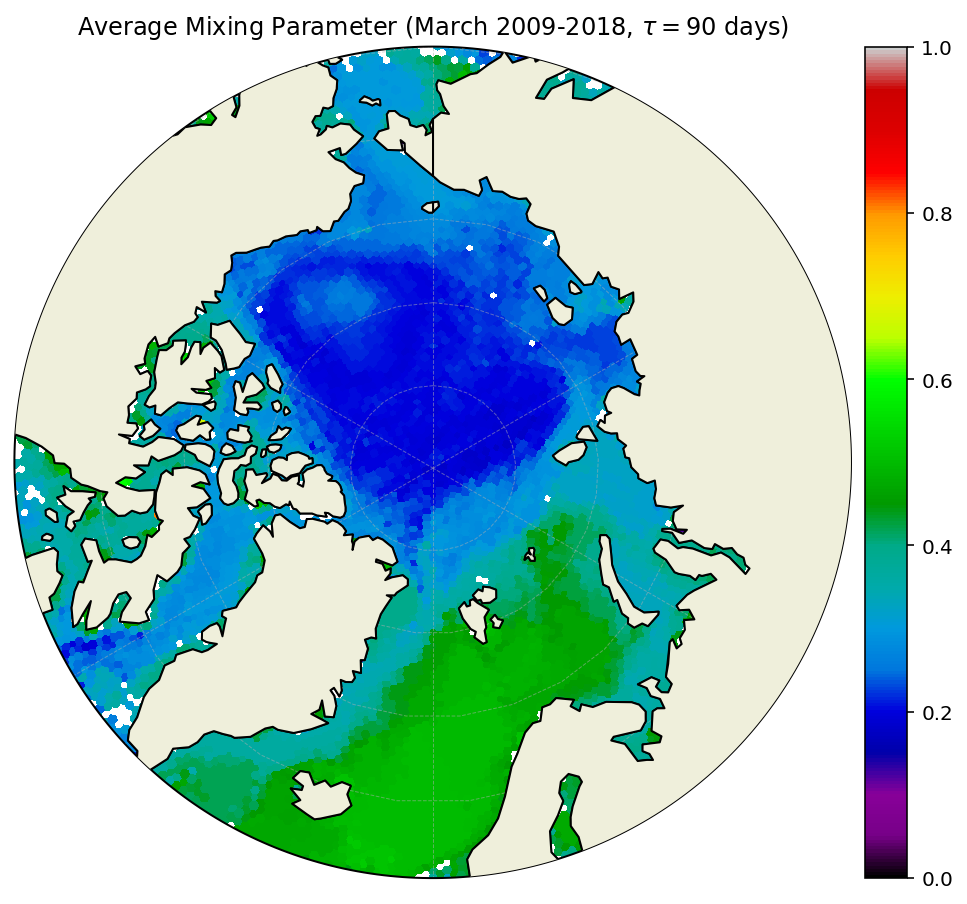

In [14]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_march_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"mixing_Rcmems_Pico11_S20092018-3-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Mixing Parameter (March 2009-2018, $\tau=90$ days)",
                                            )

## September 2009-2018

In [7]:
avg_mixing_september_2009_2018 = np.zeros_like(myBins.bindex)
avg_coherence_september_2009_2018 = np.zeros_like(myBins.bindex)
avg_boundary_september_2009_2018 = np.zeros_like(myBins.bindex)
avg_global_mixing_september_2009_2018 = 0
avg_global_coherence_september_2009_2018 = 0

for year in range(2009, 2019):
    runName = f"Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24"
    comName = runName + "_Cico7_mt2"
    
    transMat = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")
    
    myBins.load_communities(comdir + f"masked_network_{comName}.clu")
    myBins.find_adjacency();
    myBins.flag_on_boundary();
    myBins.color_communities();
    myBins.calculate_coherence_ratio(transMat);
    myBins.calculate_global_coherence()
    myBins.calculate_mixing(transMat);
    myBins.calculate_global_mixing()
    
    avg_mixing_september_2009_2018 = avg_mixing_september_2009_2018 + myBins.mixing
    avg_coherence_september_2009_2018 = avg_coherence_september_2009_2018 + myBins.coherenceRatio
    avg_boundary_september_2009_2018 = avg_boundary_september_2009_2018 + myBins.onBoundary
    avg_global_coherence_september_2009_2018 += myBins.globalCoherenceRatio
    avg_global_mixing_september_2009_2018 += myBins.globalMixing
    
avg_mixing_september_2009_2018 = avg_mixing_september_2009_2018/10
avg_coherence_september_2009_2018 = avg_coherence_september_2009_2018/10
avg_boundary_september_2009_2018 = avg_boundary_september_2009_2018/10
avg_global_mixing_september_2009_2018 = avg_global_mixing_september_2009_2018/10
avg_global_coherence_september_2009_2018 = avg_global_coherence_september_2009_2018/10
print("Average Global Coherence Ratio", avg_global_coherence_september_2009_2018)
print("Average Global Mixing Parameter", avg_global_mixing_september_2009_2018)

Average Global Coherence Ratio 0.7852205304602252
Average Global Mixing Parameter 0.3826760162569824


In [10]:
multiFiles = []
for year in range(2009, 2019):
    for month in ["09", "10", "11"]:
        multiFiles.append(f"/data/oceanparcels/input_data/CMEMS/GLOBAL_REANALYSIS_PHY_001_030_monthly/mercatorglorys12v1_gl12_mean_{year}{month}.nc")
ds_septoctnov_20092018 = xr.open_mfdataset(multiFiles) 

/science/users/4302001/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """
/science/users/4302001/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [32]:
ds_septoctnov_20092018.uo[:, 0, 1680:, :]

<xarray.DataArray 'uo' (time: 30, latitude: 361, longitude: 4320)>
dask.array<getitem, shape=(30, 361, 4320), dtype=float32, chunksize=(1, 361, 4320)>
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.91667 ... 179.83333 179.91667
    depth      float32 0.494025
  * latitude   (latitude) float32 60.0 60.083332 60.166668 ... 89.916664 90.0
  * time       (time) datetime64[ns] 2009-09-16 ... 2018-11-16
Attributes:
    long_name:      Eastward velocity
    standard_name:  eastward_sea_water_velocity
    units:          m s-1
    unit_long:      Meters per second
    cell_methods:   area: mean

In [33]:
meanvelo_septoctnov_20092018 = np.mean(np.sqrt(np.square(ds_septoctnov_20092018.uo[:, 0, 1680:, :]) + np.square(ds_septoctnov_20092018.vo[:, 0, 1680:, :])), axis=0).compute()

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [34]:
meanvelo_septoctnov_20092018.shape

(361, 4320)

In [47]:
meansiconc = np.mean(ds_septoctnov_20092018.siconc[:, 1680:, :], axis=0)

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


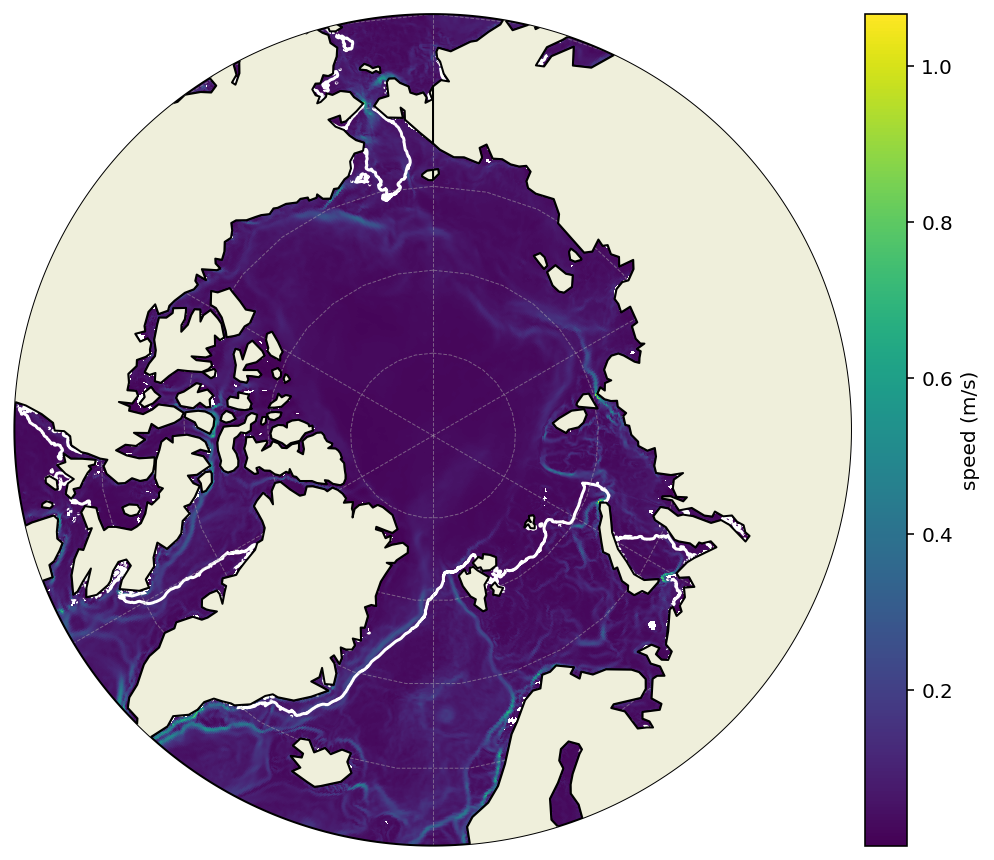

In [48]:
fig, ax = plot.field_from_dataset(ds_septoctnov_20092018.longitude, 
                                    ds_septoctnov_20092018.latitude[1680:], 
                                    meanvelo_septoctnov_20092018, 
                                    latRange=(60,90), 
                                    polar=True,
                                    size=(8,8),
                                    land=True,
                                    units = "speed (m/s)")
ax.contour(ds_septoctnov_20092018.longitude, 
           ds_septoctnov_20092018.latitude[1680:], 
           meansiconc, levels=np.array([0.15]), 
           colors='white', 
           transform=ccrs.PlateCarree())

In [52]:
meshlon, meshlat= np.meshgrid(ds_septoctnov_20092018.longitude, ds_septoctnov_20092018.latitude[1680:])
dataPoints = np.dstack((meshlon.flatten(), meshlat.flatten()))[0]
veloVals = np.where(np.isnan(meanvelo_septoctnov_20092018.data.flatten()), 0, meanvelo_septoctnov_20092018.data.flatten())
binPoints = np.dstack((myBins.lons[myMask[3]], myBins.lats[myMask[3]]))[0]
interpolatedVelocity = griddata(dataPoints, veloVals, binPoints, method="nearest")

In [63]:
meshlon, meshlat= np.meshgrid(ds_septoctnov_20092018.longitude, ds_septoctnov_20092018.latitude[1680:])
dataPoints = np.dstack((meshlon.flatten(), meshlat.flatten()))[0]
iceVals = np.where(np.isnan(meansiconc.data.flatten()), 0, meansiconc.data.flatten())
binPoints = np.dstack((myBins.lons[myMask[3]], myBins.lats[myMask[3]]))[0]
interpolatedIce = griddata(dataPoints, iceVals, binPoints, method="nearest")

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


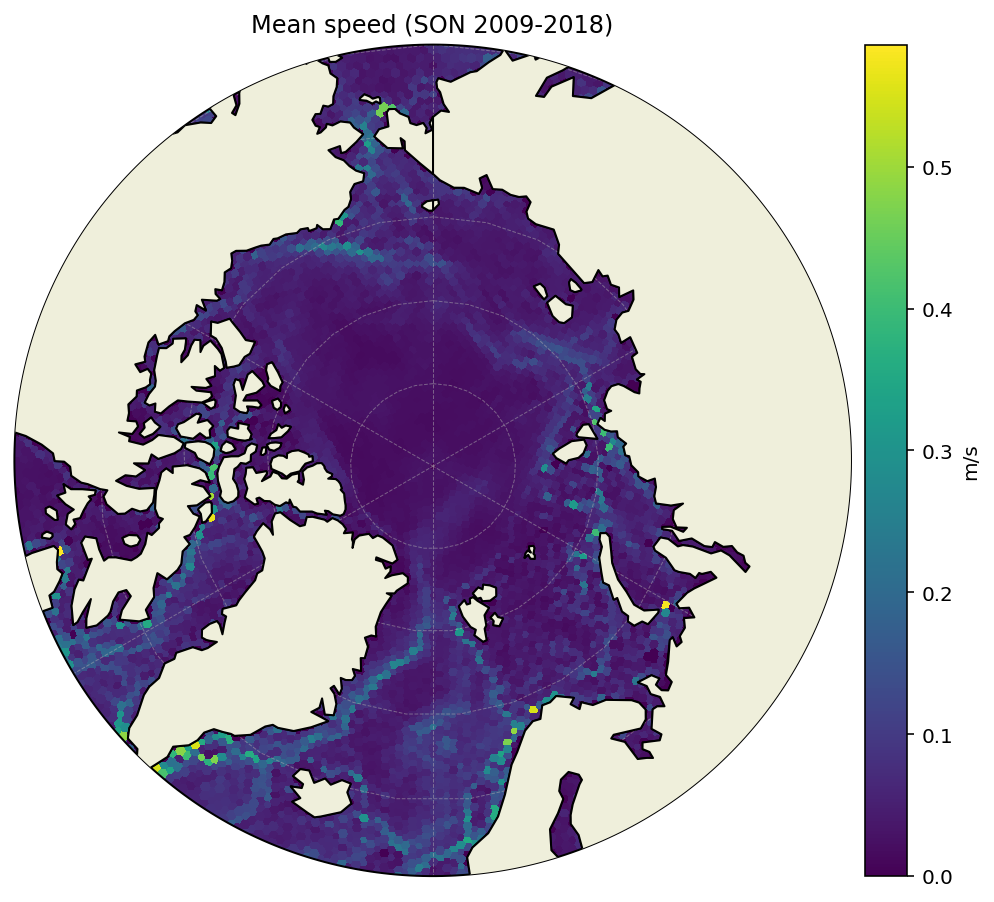

In [54]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             interpolatedVelocity[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (8,8),
                                             cbar = True,
                                             polar = True,
                                             title = r"Mean speed (SON 2009-2018)",
                                             units = "m/s"
                                            )

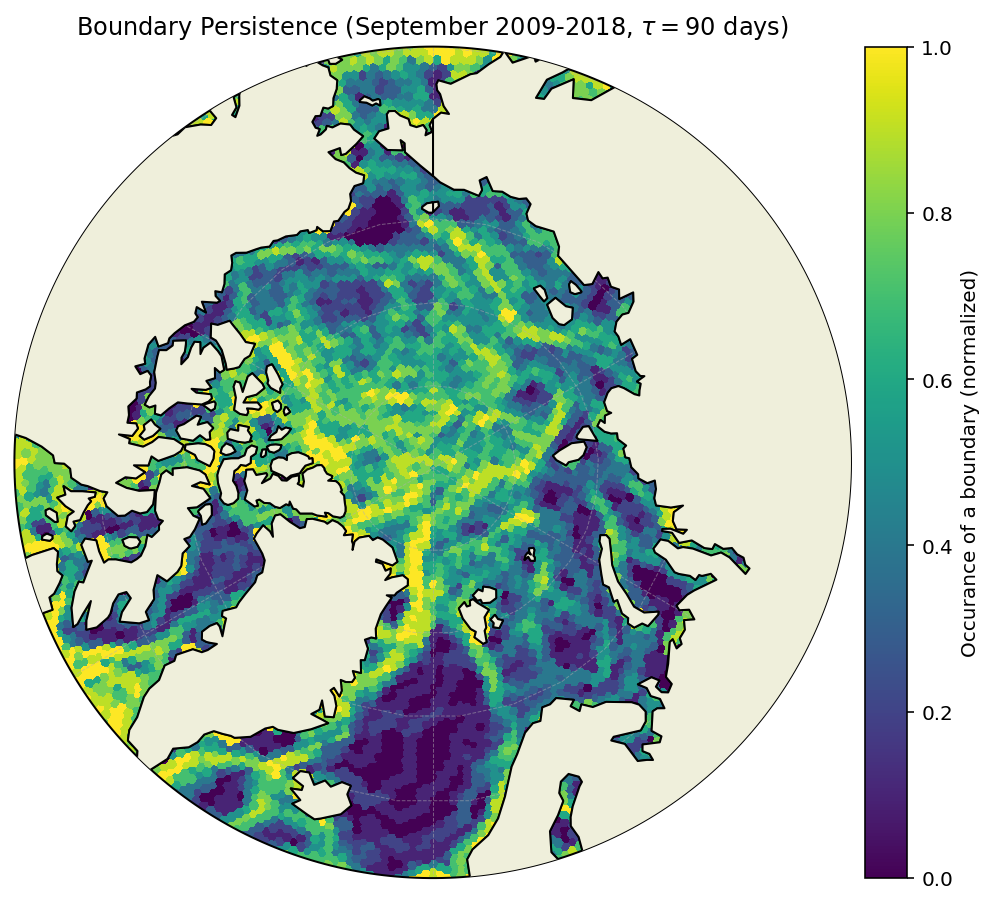

In [16]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_september_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (8,8),
                                             export = f"persistence_Rcmems_Pico11_S20092018-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Boundary Persistence (September 2009-2018, $\tau=90$ days)",
                                             units = "Occurance of a boundary (normalized)"
                                            )

In [69]:
from scipy.stats import pearsonr

In [70]:
icemask = interpolatedIce < 0.15
pearsonr(interpolatedVelocity[np.logical_or(myBins.oceanMask, icemask)],
         avg_boundary_september_2009_2018[np.logical_or(myBins.oceanMask, icemask)])

/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/science/users/4302001/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(0.36327812816302973, 0.0)

In [71]:
icemask = interpolatedIce < 0.15
pearsonr(interpolatedVelocity[myBins.oceanMask],
         avg_boundary_september_2009_2018[myBins.oceanMask])

(-0.01540188978964058, 0.2104170961525013)

In [67]:
myBins.oceanMask

array([ True, False,  True, ...,  True,  True,  True])

0

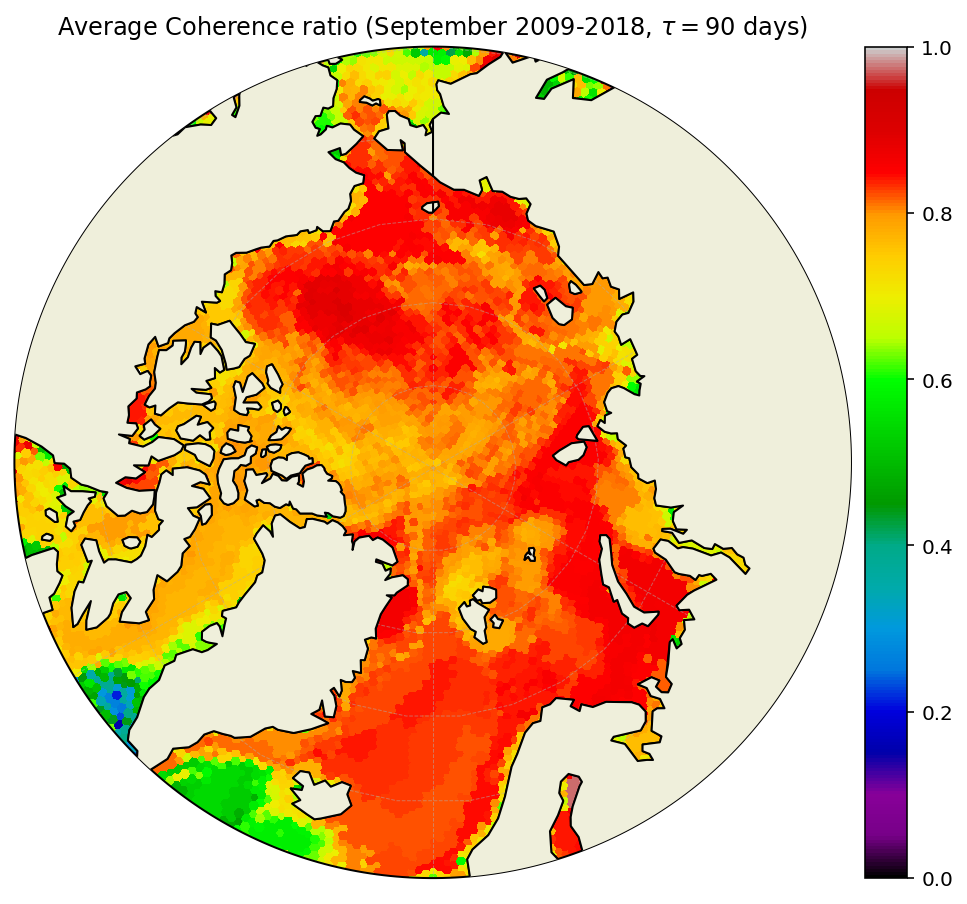

In [17]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_september_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"coherence_Rcmems_Pico11_S20092018-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Coherence ratio (September 2009-2018, $\tau=90$ days)",
                                            )

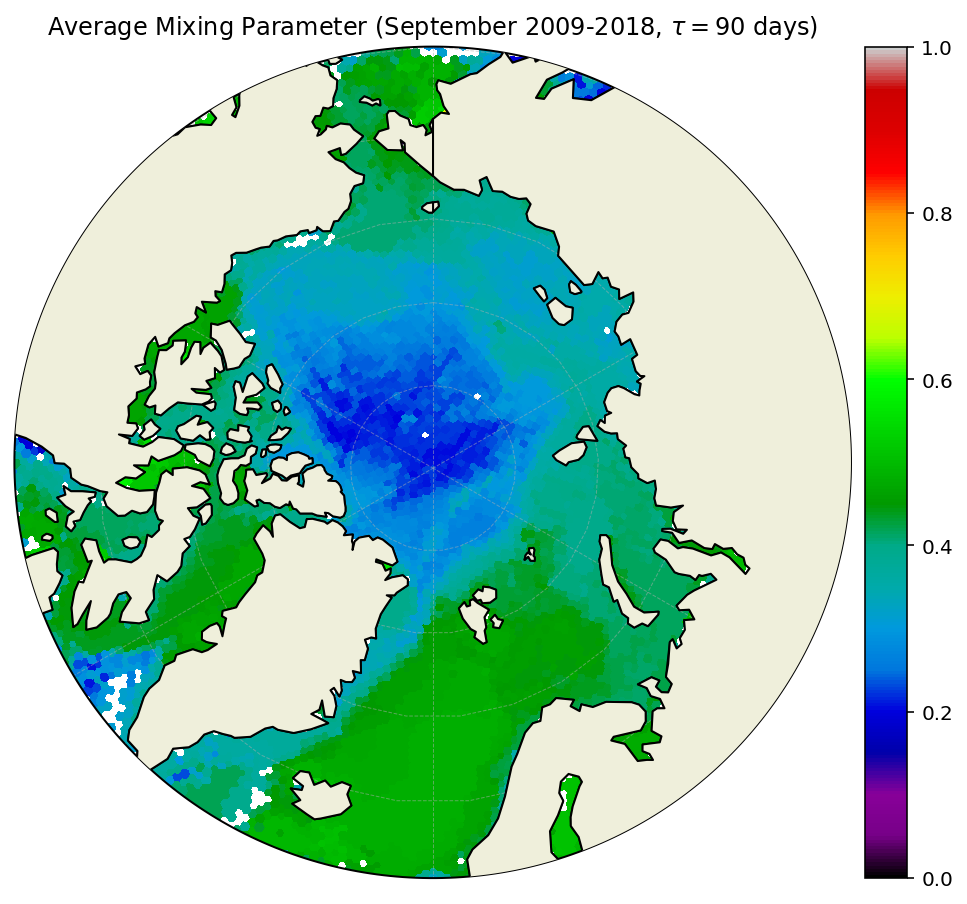

In [18]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_september_2009_2018[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"mixing_Rcmems_Pico11_S20092018-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Mixing Parameter (September 2009-2018, $\tau=90$ days)",
                                            )

## March 1993-2002 (90 Days)

In [22]:
avg_mixing_march_1993_2002 = np.zeros_like(myBins.bindex)
avg_coherence_march_1993_2002 = np.zeros_like(myBins.bindex)
avg_boundary_march_1993_2002 = np.zeros_like(myBins.bindex)
avg_global_mixing_march_1993_2002 = 0
avg_global_coherence_march_1993_2002 = 0

for year in range(1993, 2003):
    runName = f"Rcmems_Pico11_S{year}-3-1_D90_DT20_ODT24"
    comName = runName + "_Cico7_mt2"
    
    transMat = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")
    
    myBins.load_communities(comdir + f"masked_network_{comName}.clu")
    myBins.find_adjacency();
    myBins.flag_on_boundary();
    myBins.color_communities();
    myBins.calculate_coherence_ratio(transMat);
    myBins.calculate_global_coherence()
    myBins.calculate_mixing(transMat);
    myBins.calculate_global_mixing()
    
    avg_mixing_march_1993_2002 = avg_mixing_march_1993_2002 + myBins.mixing
    avg_coherence_march_1993_2002 = avg_coherence_march_1993_2002 + myBins.coherenceRatio
    avg_boundary_march_1993_2002 = avg_boundary_march_1993_2002 + myBins.onBoundary
    avg_global_coherence_march_1993_2002 += myBins.globalCoherenceRatio
    avg_global_mixing_march_1993_2002 += myBins.globalMixing
    
avg_mixing_march_1993_2002 = avg_mixing_march_1993_2002/10
avg_coherence_march_1993_2002 = avg_coherence_march_1993_2002/10
avg_boundary_march_1993_2002 = avg_boundary_march_1993_2002/10
avg_global_mixing_march_1993_2002 = avg_global_mixing_march_1993_2002/10
avg_global_coherence_march_1993_2002 = avg_global_coherence_march_1993_2002/10
print("Average Global Coherence Ratio", avg_global_coherence_march_1993_2002)
print("Average Global Mixing Parameter", avg_global_mixing_march_1993_2002)

Average Global Coherence Ratio 0.7897345120726125
Average Global Mixing Parameter 0.33440586808189054


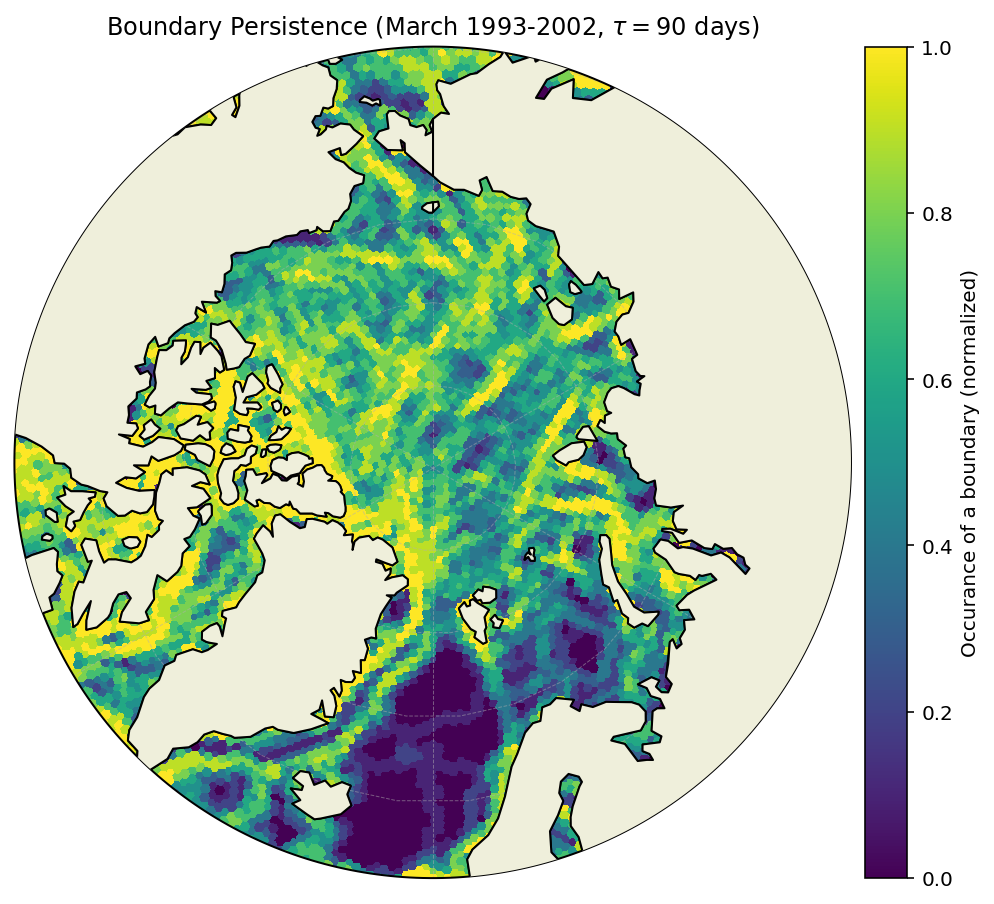

In [23]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_march_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (8,8),
                                             export = f"persistence_Rcmems_Pico11_S19932002-3-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Boundary Persistence (March 1993-2002, $\tau=90$ days)",
                                             units = "Occurance of a boundary (normalized)"
                                            )

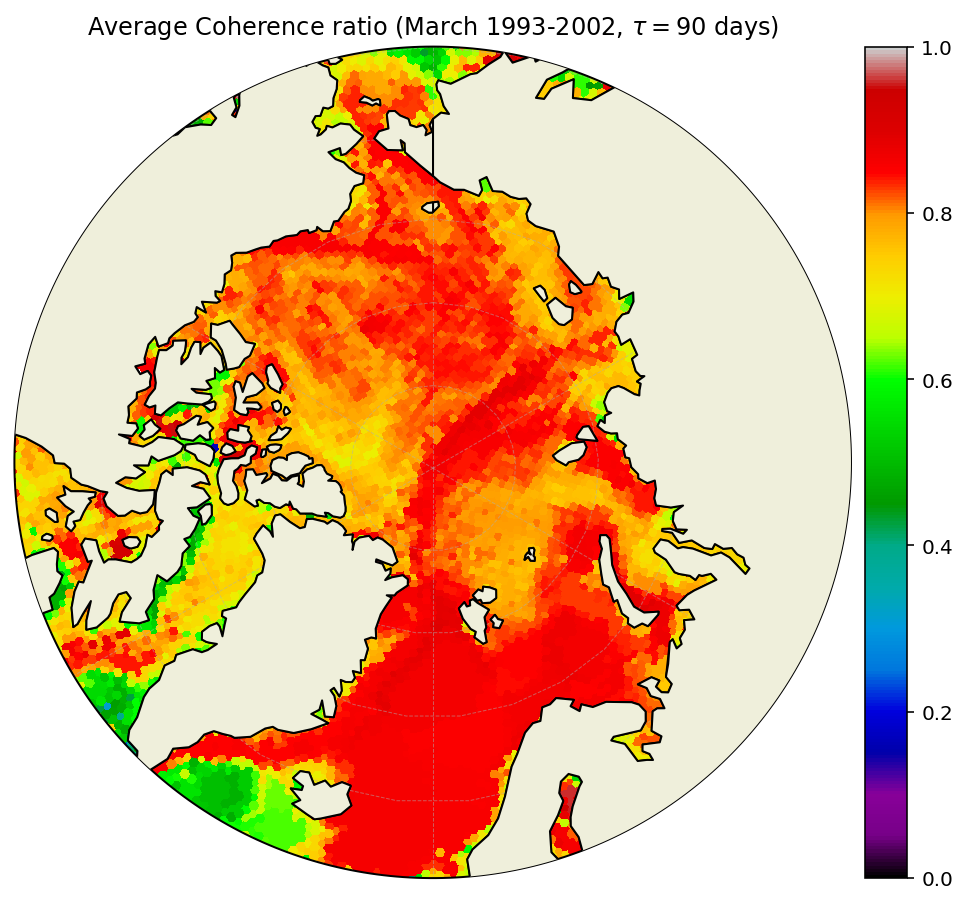

In [24]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_march_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"coherence_Rcmems_Pico11_S19932002-3-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Coherence ratio (March 1993-2002, $\tau=90$ days)",
                                            )

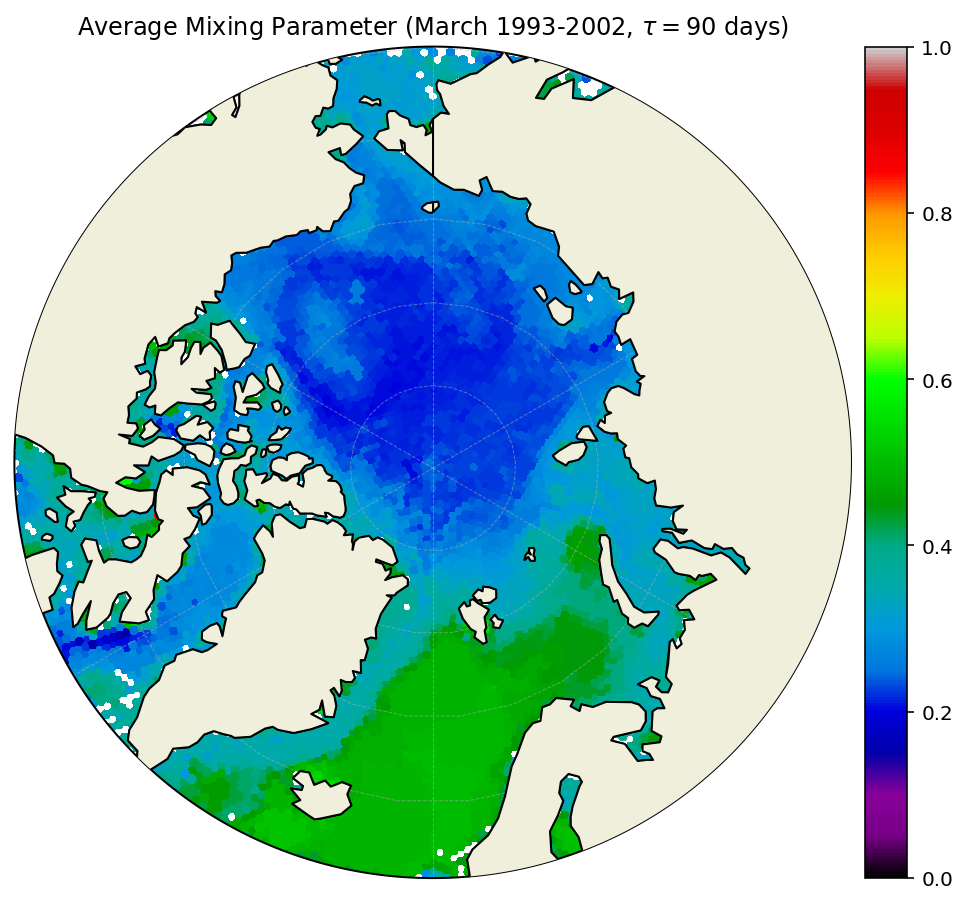

In [25]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_march_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"mixing_Rcmems_Pico11_S19932002-3-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Mixing Parameter (March 1993-2002, $\tau=90$ days)",
                                            )

## September 1993-2002

In [26]:
avg_mixing_september_1993_2002 = np.zeros_like(myBins.bindex)
avg_coherence_september_1993_2002 = np.zeros_like(myBins.bindex)
avg_boundary_september_1993_2002 = np.zeros_like(myBins.bindex)
avg_global_mixing_september_1993_2002 = 0
avg_global_coherence_september_1993_2002 = 0

for year in range(1993, 2003):
    runName = f"Rcmems_Pico11_S{year}-9-1_D90_DT20_ODT24"
    comName = runName + "_Cico7_mt2"
    
    transMat = community.transMat.from_counter_npz(matdir + f"masked_counter_{runName}_Cico7.npz")
    
    myBins.load_communities(comdir + f"masked_network_{comName}.clu")
    myBins.find_adjacency();
    myBins.flag_on_boundary();
    myBins.color_communities();
    myBins.calculate_coherence_ratio(transMat);
    myBins.calculate_global_coherence()
    myBins.calculate_mixing(transMat);
    myBins.calculate_global_mixing()
    
    avg_mixing_september_1993_2002 = avg_mixing_september_1993_2002 + myBins.mixing
    avg_coherence_september_1993_2002 = avg_coherence_september_1993_2002 + myBins.coherenceRatio
    avg_boundary_september_1993_2002 = avg_boundary_september_1993_2002 + myBins.onBoundary
    avg_global_coherence_september_1993_2002 += myBins.globalCoherenceRatio
    avg_global_mixing_september_1993_2002 += myBins.globalMixing
    
avg_mixing_september_1993_2002 = avg_mixing_september_1993_2002/10
avg_coherence_september_1993_2002 = avg_coherence_september_1993_2002/10
avg_boundary_september_1993_2002 = avg_boundary_september_1993_2002/10
avg_global_mixing_september_1993_2002 = avg_global_mixing_september_1993_2002/10
avg_global_coherence_september_1993_2002 = avg_global_coherence_september_1993_2002/10
print("Average Global Coherence Ratio", avg_global_coherence_september_1993_2002)
print("Average Global Mixing Parameter", avg_global_mixing_september_1993_2002)

Average Global Coherence Ratio 0.7919039942230969
Average Global Mixing Parameter 0.3662599744755023


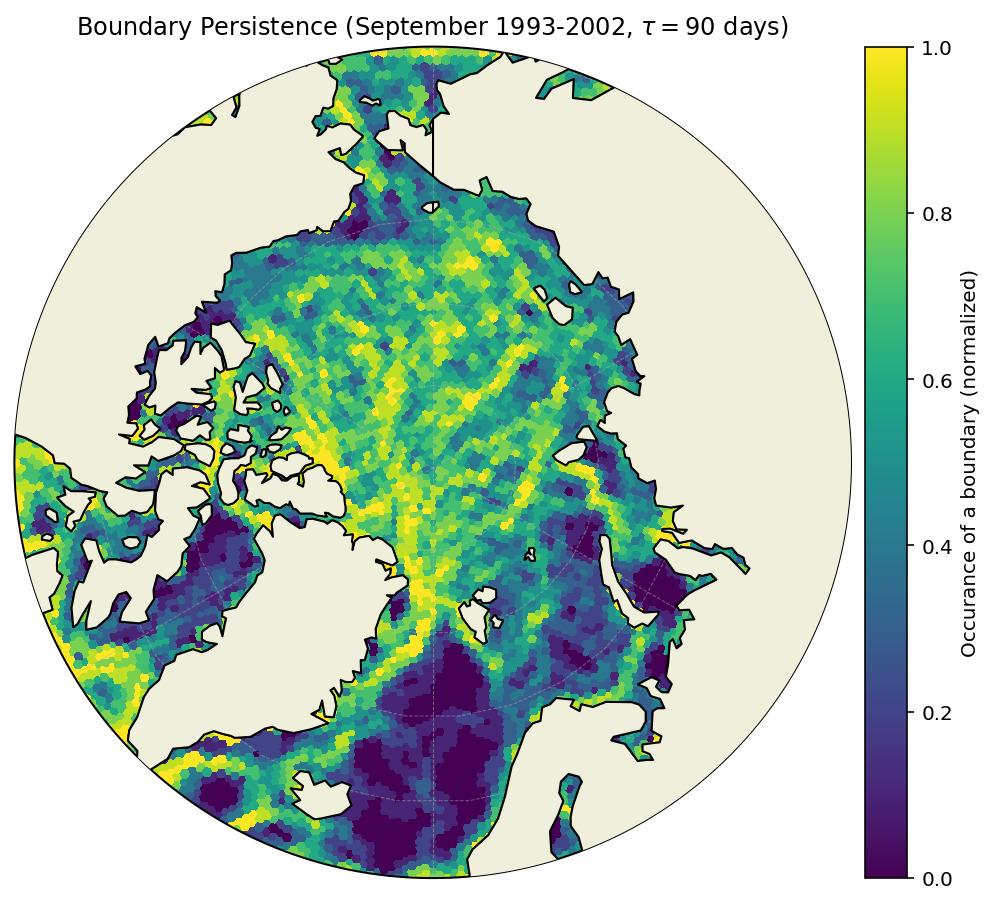

In [27]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_boundary_september_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             size = (8,8),
                                             export = f"persistence_Rcmems_Pico11_S19932002-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Boundary Persistence (September 1993-2002, $\tau=90$ days)",
                                             units = "Occurance of a boundary (normalized)"
                                            )

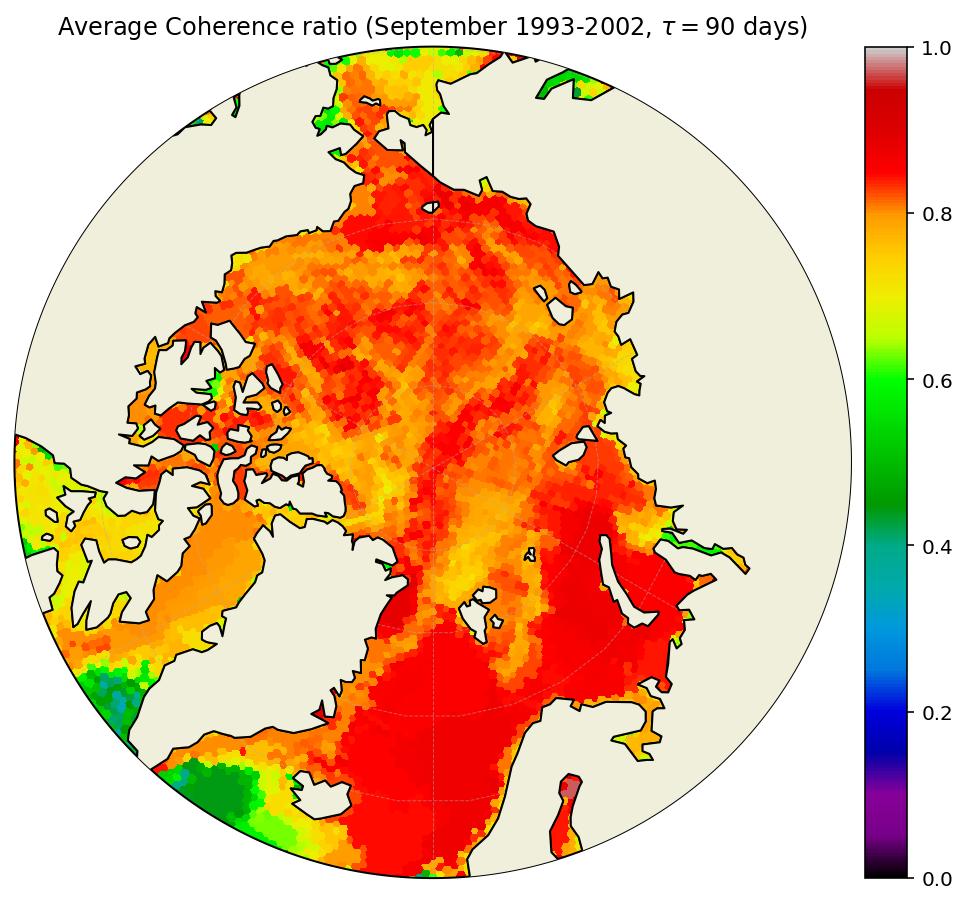

In [28]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_coherence_september_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"coherence_Rcmems_Pico11_S19932002-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Coherence ratio (September 1993-2002, $\tau=90$ days)",
                                            )

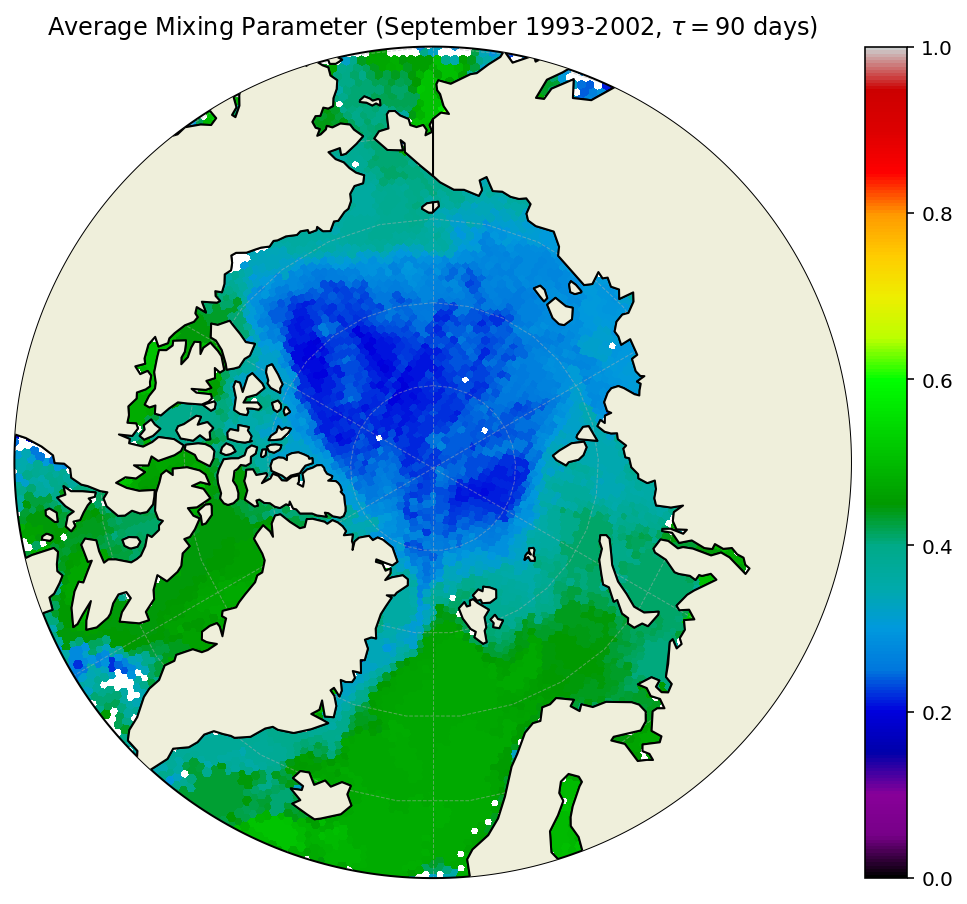

In [29]:
fig, ax = plot.triangular_field_from_dataset(myBins.svTriLons, 
                                             myBins.svTriLats, 
                                             myBins.svSimplices[myBins.svDomainMask], 
                                             avg_mixing_september_1993_2002[myBins.hexBindex][myBins.svSimplices[:,0][myBins.svDomainMask]], 
                                             lonRange = (-180, 180),
                                             latRange = (60, 90),
                                             land = True,
                                             colormap = "nipy_spectral",
                                             size = (8,8),
                                             export = f"mixing_Rcmems_Pico11_S19932002-9-1_D90_DT20_ODT24_Cico7_mt2.png",
                                             cbar = True,
                                             polar = True,
                                             vmin = 0,
                                             vmax = 1,
                                             title = r"Average Mixing Parameter (September 1993-2002, $\tau=90$ days)",
                                            )